# Capítulo 5 - Parte 1: Q-Learning, SARSA e Expected-SARSA


Você pode rodar este notebook localmente ou no Colab. Para abrir diretamente no Colab, basta clicar no link abaixo.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/cap05/cap05-main-1.ipynb)

## 1. Configurações Iniciais

### Para Rodar no Colab

Nesta versão, você pode rodar a célula abaixo, mesmo sem estar no Colab.

In [2]:
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # for saving videos
    !apt-get install ffmpeg freeglut3-dev xvfb

    !pip install gym==0.23.1

    # clone repository
    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

from IPython.display import clear_output

clear_output()

In [3]:
if IN_COLAB:
    # Set up fake display; otherwise rendering will fail
    import os
    os.system("Xvfb :1 -screen 0 1024x768x24 &")
    os.environ['DISPLAY'] = ':1'

    from util.notebook import display_videos_from_path

### Imports Gerais

In [4]:
import gym
import numpy as np

In [5]:
from util.experiments import test_greedy_Q_policy, repeated_exec
from util.plot import plot_result, plot_multiple_results
from util.wrappers import DiscreteObservationWrapper

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/content/rl_facil/util/wrappers.py:31: DeprecationWarning: invalid escape sequence '\g'
  '''Classe para converter espaços contínuos em espaços discretos.


In [6]:
# define se os algoritmos vão imprimir dados do treinamento
VERBOSE = True

## 1. Q-Learning (Revisão)

In [7]:
# Esta é a política. Neste caso, escolhe uma ação com base nos valores
# da tabela Q, usando uma estratégia epsilon-greedy.
def epsilon_greedy(Q, state, num_actions, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(0, num_actions)
    else:
        return np.argmax(Q[state])

In [8]:
# Algoritmo Q-learning, online learning (TD-learning)
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_qlearning(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1, render=False):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q com valores aleatórios de -1.0 a 0.0
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.random.uniform(low = -1.0, high = 0.0,
                          size = (env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-discontado)
    sum_rewards_per_ep = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state = env.reset()

        # executa um episódio completo, fazendo atualizações na Q-table
        while not done:
            # exibe/renderiza os passos no ambiente, durante 1 episódio a cada mil e também nos últimos 5 episódios
            if render and (i >= (episodes - 5) or (i+1) % 1000 == 0):
                env.render()

            # escolhe a próxima ação -- usa epsilon-greedy
            action = epsilon_greedy(Q, state, num_actions, epsilon)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, done, _ = env.step(action)

            if done:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor máximo (melhor ação)
                V_next_state = np.max(Q[next_state])

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state

        sum_rewards_per_ep.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i+1) % 100 == 0):
            avg_reward = np.mean(sum_rewards_per_ep[-100:])
            print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return sum_rewards_per_ep, Q

In [9]:
#ENV_NAME, r_max = "Taxi-v3", 10
ENV_NAME, r_max = "CliffWalking-v0", 0

EPISODES = 5000
LR = 0.01
GAMMA = 0.95
EPSILON = 0.1

env = gym.make(ENV_NAME)

# Roda o algoritmo Q-Learning
rewards, Qtable = run_qlearning(env, EPISODES, LR, GAMMA, EPSILON, render=False)
clear_output()

print("Últimos resultados: media =", np.mean(rewards[-20:]), ", desvio padrao =", np.std(rewards[-20:]))

Últimos resultados: media = -30.7 , desvio padrao = 50.77410757462902


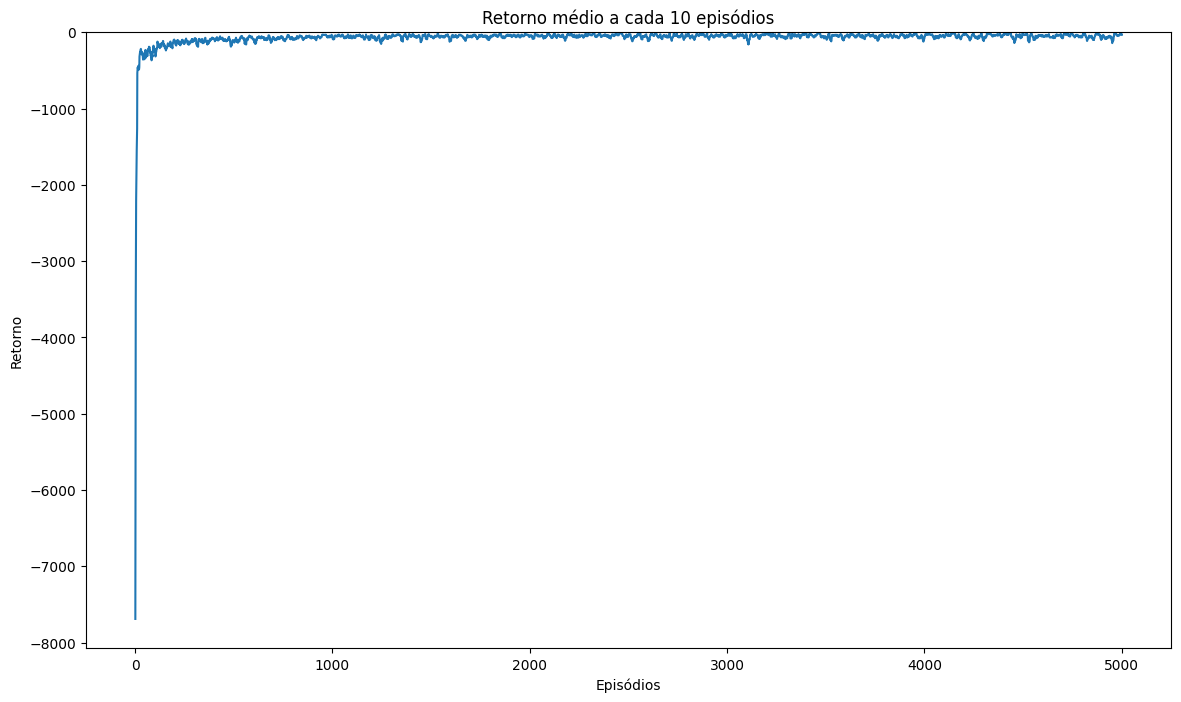

In [10]:
# Mostra um gráfico de episódios x retornos não descontados
plot_result(rewards, r_max, None)

In [ ]:
test_greedy_Q_policy(env, Qtable, 1, render=True)

## 2. SARSA

O **SARSA** é um algoritmo semelhante ao Q-Learning. Porém, ele usa um valor de $Q_{target}$ baseado na próxima ação ($a'$) executada.

Em outras palavras, o Q-Learning:
- usa os dados $(s,a,r,s')$ para fazer uma atualização no $Q(s,a)$
- assume que o valor do próximo estado é (guloso) baseado na melhor ação possível: $V(s') = max_{a'}{Q(s', a')}$

Porém, o SARSA:
- usa os dados $(s,a,r,s',a')$ para fazer uma atualização no $Q(s,a)$
- assume que o valor do próximo estado é o resultado da próxima ação $a'$: $V(s') = Q(s', a')$

Crie o código do SARSA abaixo, com base no código do Q-Learning:

In [12]:
# Algoritmo SARSA, online learning (TD-learning)
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_sarsa(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1, render=False):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q com valores aleatórios de -1.0 a 0.0
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.random.uniform(low = -1.0, high = 0.0,
                          size = (env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-discontado)
    sum_rewards_per_ep = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        # FAZER AQUI...

        # ATÉ AQUI....

        sum_rewards_per_ep.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i+1) % 100 == 0):
            avg_reward = np.mean(sum_rewards_per_ep[-100:])
            print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return sum_rewards_per_ep, Q

Se não conseguir, descomente o código abaixo para prosseguir:

In [13]:
#from cap05.nstep_sarsa import run_nstep_sarsa
#run_sarsa = lambda env, epi, lr, gamma, eps, render=False : run_nstep_sarsa(env, epi, 1, lr, gamma, eps, render=render)

In [14]:
#ENV_NAME, r_max = "Taxi-v3", 10
ENV_NAME, r_max = "CliffWalking-v0", 0

EPISODES = 5000
LR = 0.01
GAMMA = 0.95
EPSILON = 0.1

env = gym.make(ENV_NAME)

# Roda o algoritmo SARSA
rewards, Qtable = run_sarsa(env, EPISODES, LR, GAMMA, EPSILON, render=False)
clear_output()

print("Últimos resultados: media =", np.mean(rewards[-20:]), ", desvio padrao =", np.std(rewards[-20:]))

Últimos resultados: media = -18.2 , desvio padrao = 3.026549190084311


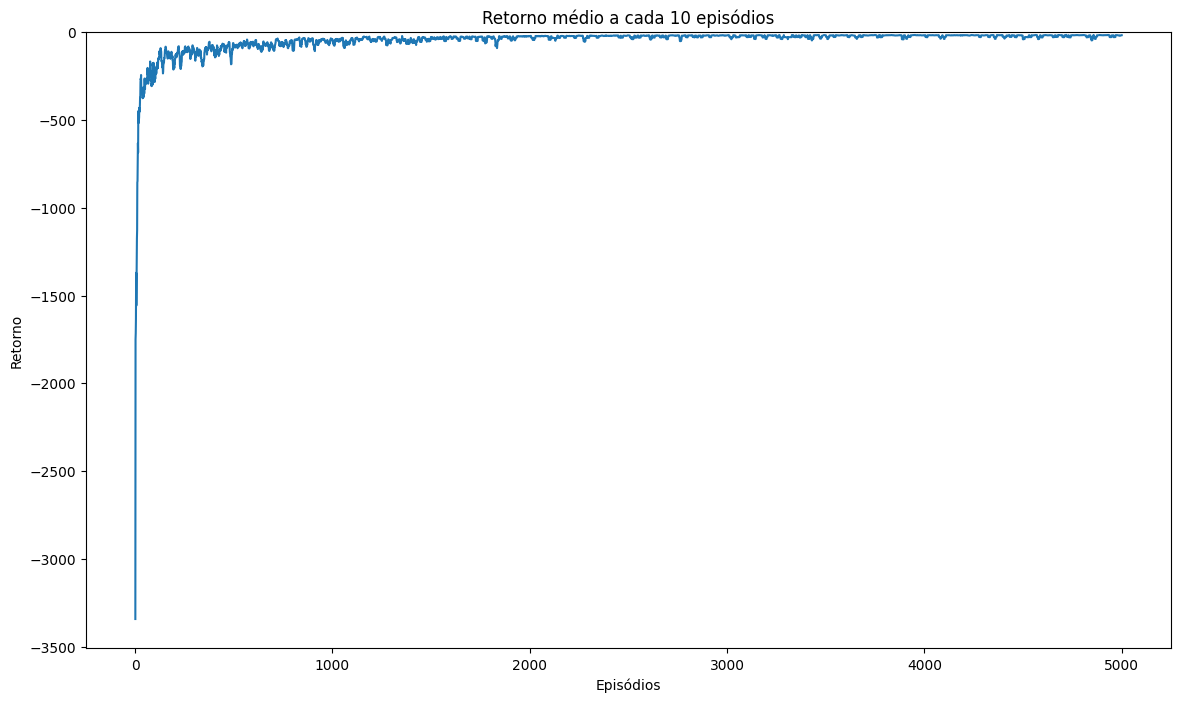

In [15]:
# Mostra um gráfico de episódios x retornos não descontados
plot_result(rewards, r_max, None)

In [16]:
#test_greedy_Q_policy(env, Qtable, 1, render=True)

## 3. Expected-SARSA

O Expected-SARSA tem semelhanças com os dois algoritmos vistos antes:
- usa os dados $(s,a,r,s')$ para fazer uma atualização no $Q(s,a)$
- assume que o valor do próximo estado é o valor médio, com base nas probabilidades dadas pela política:
   $$V(s') = \displaystyle\sum_{a'} \pi(a'|s') \times Q(s',a')$$

Para implementá-lo, precisamos das probabilidades da política realizar cada ação.

A função abaixo retorna as probabilidades de cada ação, na política *epsilon-greedy*:

In [17]:
def epsilon_greedy_probs(Q, state, num_actions, epsilon):
    # lista com a probabilidade que todas as ações têm de ser escolhidas nas decisões exploratórias (não-gulosas)
    probs = [ (epsilon / num_actions) ] * num_actions

    # adiciona a probabilidade para a ação 'greedy'
    # em caso de empate, só o menor índice é considerado, mas isso é coerente com a implementação de epsilon_greedy()
    greedy_action = np.argmax(Q[state])
    probs[greedy_action] += (1.0 - epsilon)

    return probs

In [18]:
# Algoritmo Expected-SARSA
def run_expected_sarsa(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1, render=False):
    num_actions = env.action_space.n

    # inicializa a tabela Q com valores aleatórios de -1.0 a 0.0
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.random.uniform(low = -1.0, high = 0.0,
                          size = (env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-discontado)
    sum_rewards_per_ep = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state = env.reset()

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # exibe/renderiza os passos no ambiente, durante 1 episódio a cada mil e também nos últimos 5 episódios
            if render and (i >= (episodes - 5) or (i+1) % 1000 == 0):
                env.render()

            # escolhe a próxima ação -- usa epsilon-greedy
            action = epsilon_greedy(Q, state, num_actions, epsilon)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, done, _ = env.step(action)

            if done:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor esperado
                p_next_actions = epsilon_greedy_probs(Q, next_state, num_actions, epsilon)
                V_next_state = np.sum( p_next_actions * Q[next_state] )

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state

        # salva o retorno do episódio que encerrou
        sum_rewards_per_ep.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i+1) % 100 == 0):
            avg_reward = np.mean(sum_rewards_per_ep[-100:])
            print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return sum_rewards_per_ep, Q


Últimos resultados: media = -16.8 , desvio padrao = 1.6911534525287764


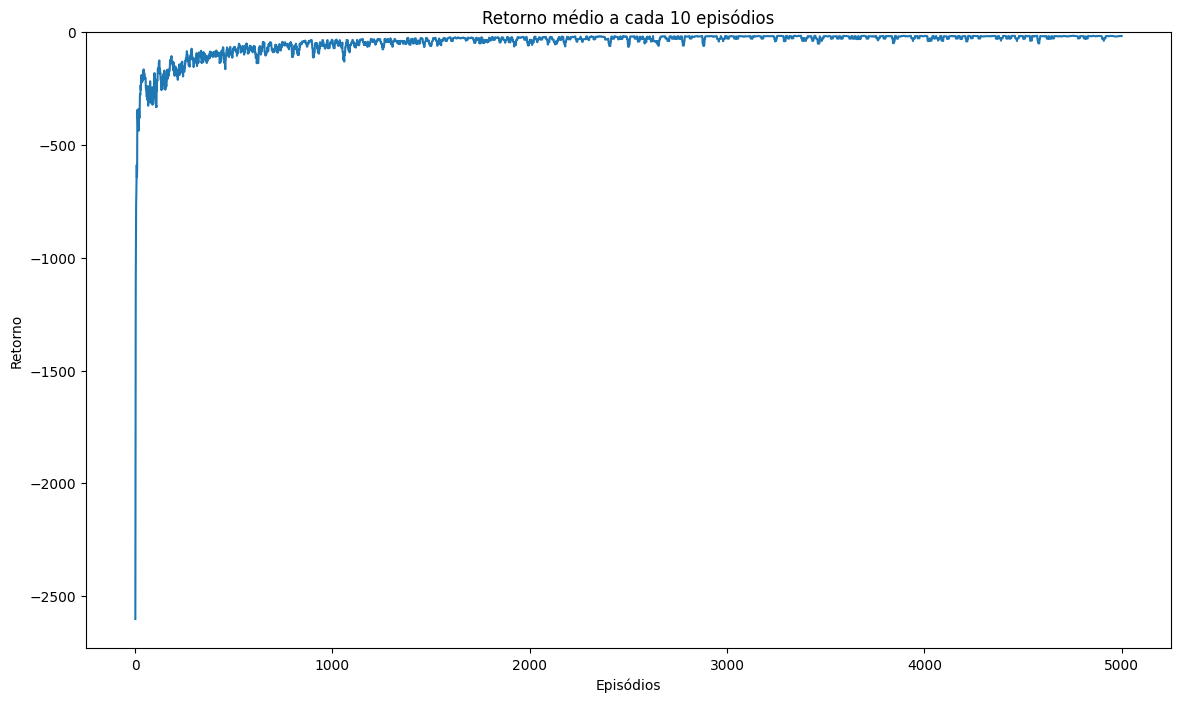

In [19]:
#ENV_NAME, r_max = "Taxi-v3", 10
ENV_NAME, r_max = "CliffWalking-v0", 0

EPISODES = 5000
LR = 0.01
GAMMA = 0.95
EPSILON = 0.1

env = gym.make(ENV_NAME)

rewards, Qtable = run_expected_sarsa(env, EPISODES, LR, GAMMA, EPSILON, render=False)
clear_output()

print("Últimos resultados: media =", np.mean(rewards[-20:]), ", desvio padrao =", np.std(rewards[-20:]))

# Mostra um gráfico de episódios x retornos não descontados
plot_result(rewards, r_max, None)

## 4. Experimentos

In [20]:
# parâmetros para todos os algoritmos (não é o ideal)
LR = 0.2
GAMMA = 0.95
EPSILON = 0.05

# silencia os algoritmos
VERBOSE = False

# repetições de cada algoritmo
RUNS = 5

# para carregar automaticamente os resultados de simulações já executadas
auto_load = True

### Taxi-v3 (discreto)

In [21]:
environment = gym.make("Taxi-v3")
NUM_EPISODES = 5_000

In [22]:
results_t = []

results_t.append( repeated_exec(RUNS, f"Q-Learning", run_qlearning, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=auto_load) )
clear_output()

results_t.append( repeated_exec(RUNS, f"Sarsa", run_sarsa, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=auto_load) )
clear_output()

results_t.append( repeated_exec(RUNS, f"Exp-Sarsa", run_expected_sarsa, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=auto_load) )
clear_output()

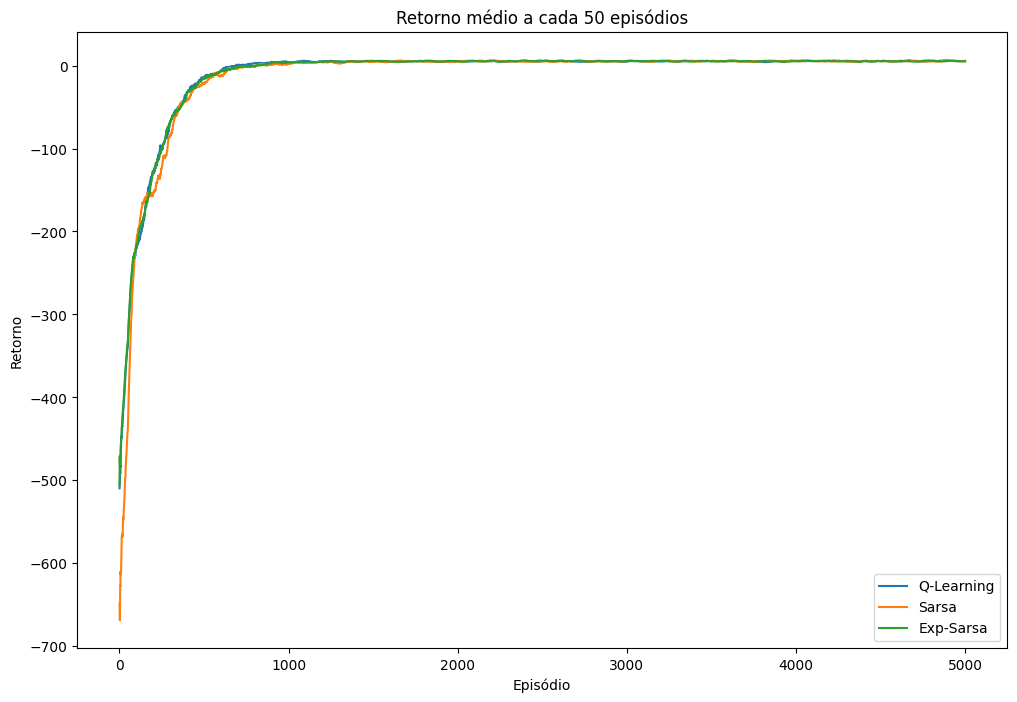

In [23]:
plot_multiple_results(results_t, cumulative=False, x_log_scale=False, window=50)

### FrozenLake-v1

In [24]:
environment = gym.make("FrozenLake-v1")
NUM_EPISODES = 8_000

In [25]:
results_f = []

results_f.append( repeated_exec(RUNS, f"Q-Learning", run_qlearning, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=auto_load) )
clear_output()

results_f.append( repeated_exec(RUNS, f"Sarsa", run_sarsa, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=auto_load) )
clear_output()

results_f.append( repeated_exec(RUNS, f"Exp-Sarsa", run_expected_sarsa, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=auto_load) )
clear_output()

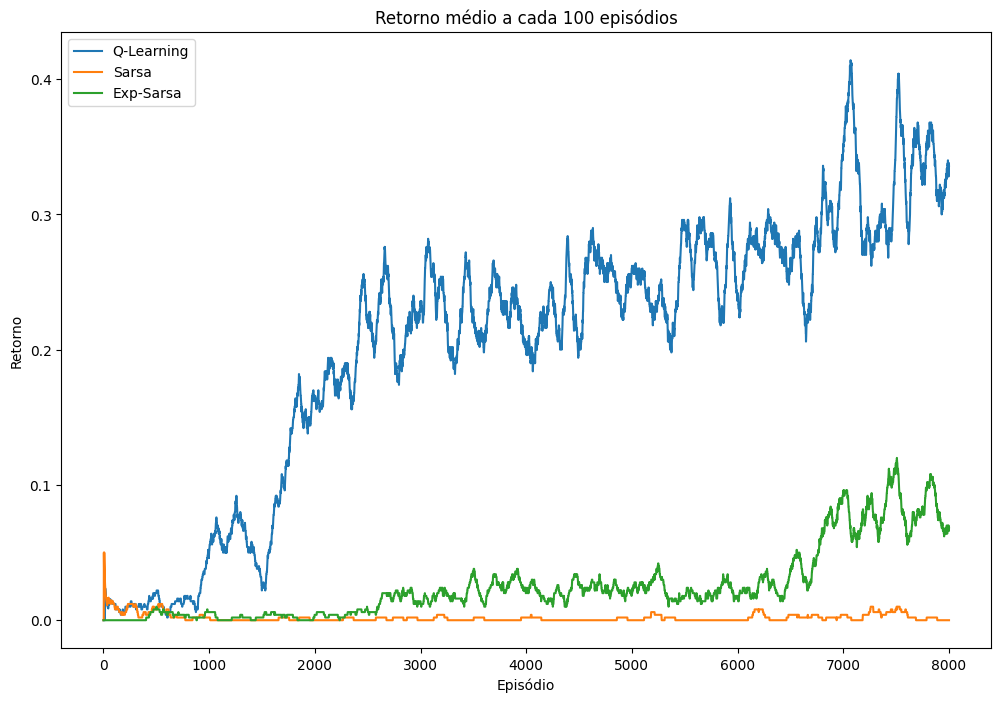

In [26]:
plot_multiple_results(results_f, cumulative=False, x_log_scale=False, window=100)

### Cliff Walking

In [27]:
environment = gym.make("CliffWalking-v0")
NUM_EPISODES = 3_000

In [28]:
results_c = []

results_c.append( repeated_exec(RUNS, f"Q-Learning", run_qlearning, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=auto_load) )
clear_output()

results_c.append( repeated_exec(RUNS, f"Sarsa", run_sarsa, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=auto_load) )
clear_output()

results_c.append( repeated_exec(RUNS, f"Exp-Sarsa", run_expected_sarsa, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=auto_load) )
clear_output()

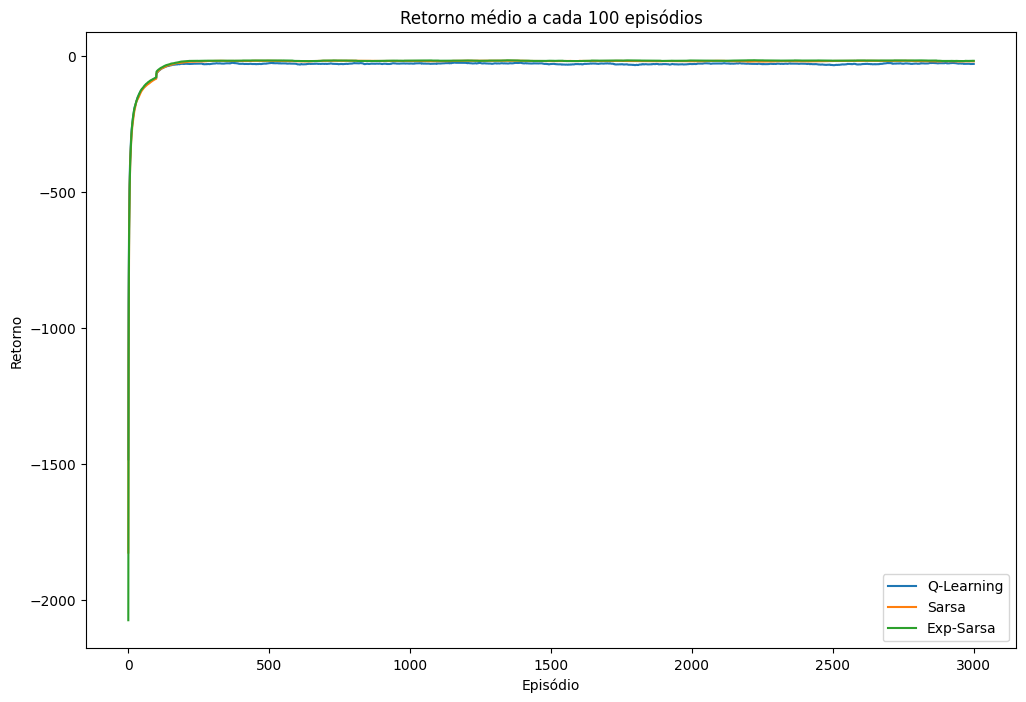

In [29]:
plot_multiple_results(results_c, cumulative=False, x_log_scale=False, window=100)